## To make things simpler, the datasets will be renamed: <br>
alik05_forest-fire-dataset = dataset1 <br> <br>
elmadafri_the-wildfire-dataset = dataset2 <br> <br>
kutaykutlu_forest-fire = dataset3 <br> <br>
mohnishsaiprasad_forest-fire-images = dataset4 <br> <br>
phylake1337_fire-dataset = dataset5 <br> <br>

In [1]:
import os
import numpy as np
from PIL import Image

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models


In [2]:
#path_to_dataset_folder = "C:/Users/RoscaMitrut/Desktop/Forest-Fire-Detection/datasets"
path_to_dataset_folder = ""

In [3]:

dataset1_path = path_to_dataset_folder + "datasets/alik05_forest-fire-dataset/Forest Fire Dataset/"
dataset2_path = path_to_dataset_folder + "datasets/elmadafri_the-wildfire-dataset/the_wildfire_dataset_2n_version/"
dataset3_path = path_to_dataset_folder + "datasets/kutaykutlu_forest-fire/"
dataset4_path = path_to_dataset_folder + "datasets/mohnishsaiprasad_forest-fire-images/Data/"
dataset5_path = path_to_dataset_folder + "datasets/phylake1337_fire-dataset/fire_dataset/"

In [4]:
def load_data_paths(dataset_path,folders_labels):
    dataset_x = []
    dataset_y = []
    for folder,label in folders_labels:
        try:
            for f in os.scandir(dataset_path+folder):
                if f.is_file() and f.name.endswith((".jpg", ".png")):
                    dataset_x.append(dataset_path+folder+"/"+f.name)
                    dataset_y.append(label)
        except:
            break                
    return dataset_x,dataset_y

# Dataset1

In [5]:
dataset1_X, dataset1_Y = load_data_paths(dataset1_path,[("Training/fire",1),("Training/nofire",0),("Testing/fire",1),("Testing/nofire",0)])

len(dataset1_X),len(dataset1_Y)

(1900, 1900)

# Dataset2

In [6]:
dataset2_X, dataset2_Y = load_data_paths(dataset2_path,[("test/fire",1),("test/nofire",0),("train/fire",1),("train/nofire",0),("val/fire",1),("val/nofire",0)])

len(dataset2_X),len(dataset2_Y)

(2699, 2699)

# Dataset3

In [7]:
dataset3_X, dataset3_Y = load_data_paths(dataset3_path,[("train_fire",1)])

len(dataset3_X),len(dataset3_Y)

(1102, 1102)

# Dataset4

In [8]:
dataset4_X, dataset4_Y = load_data_paths(dataset4_path,[("Test_Data/Fire",1),("Test_Data/Non_Fire",0),("Train_Data/Fire",1),("Train_Data/Non_Fire",0)])

len(dataset4_X),len(dataset4_Y)

(4661, 4661)

# Dataset5

In [9]:
dataset5_X, dataset5_Y = load_data_paths(dataset5_path,[("fire_images",1),("non_fire_images",0)])

len(dataset5_X),len(dataset5_Y)

(999, 999)

# Splitting and merging datasets for training

In [10]:
dataset_X = np.array(dataset1_X + dataset2_X + dataset3_X + dataset4_X + dataset5_X)
dataset_Y = np.array(dataset1_Y + dataset2_Y + dataset3_Y + dataset4_Y + dataset5_Y)

def shuffle_data(X, Y):
    indices = np.random.permutation(len(X))
    return X[indices], Y[indices]

dataset_X,dataset_Y = shuffle_data(dataset_X,dataset_Y)

X_train,X_test,Y_train,Y_test = train_test_split(dataset_X,dataset_Y,test_size=0.16)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.19)

In [11]:
del dataset1_X,dataset1_Y,dataset2_X,dataset2_Y,dataset3_X,dataset3_Y,dataset4_X,dataset4_Y,dataset5_X,dataset5_Y,dataset_X,dataset_Y
del dataset1_path,dataset2_path,dataset3_path,dataset4_path,dataset5_path,path_to_dataset_folder

# Training

In [12]:
def load_image(file_name, target_size = (256, 256)):
    raw = tf.io.read_file(file_name)
    tensor = tf.io.decode_image(raw, channels=3, expand_animations=False)
    tensor = tf.image.resize(tensor, target_size)
    tensor = tf.cast(tensor, tf.float32) / 255.0
    return tensor

def create_dataset(file_paths, labels, batch_size=32, target_size=(224, 224)):
    file_paths_tensor = tf.constant(file_paths)
    labels_tensor = tf.constant(labels, dtype=tf.float32)
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths_tensor, labels_tensor))
    
    def _load_and_preprocess(path, label):
        image = load_image(path, target_size)
        return image, label
    
    dataset = dataset.map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset
    

In [13]:
train_dataset = create_dataset(X_train, Y_train, batch_size=32, target_size=(256, 256))
test_dataset = create_dataset(X_test, Y_test, batch_size=32, target_size=(256, 256))
val_dataset = create_dataset(X_val, Y_val, batch_size=32, target_size=(256, 256))

In [14]:
model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [15]:
for data in train_dataset.take(1):
    print("Dataset element type:", type(data))
    print("Number of elements:", len(data))
    if len(data) == 2:
        images, labels = data
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)
        print("Sample labels:", labels.numpy())
        
del data,images,labels


Dataset element type: <class 'tuple'>
Number of elements: 2
Images shape: (32, 256, 256, 3)
Labels shape: (32,)
Sample labels: [1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 1. 0. 1. 1.]


In [16]:
history = model.fit(train_dataset, epochs=7, validation_data=val_dataset, verbose=1)

Epoch 1/7
242/242 [==============================] - 76s 289ms/step - loss: 0.4108 - accuracy: 0.8284 - precision: 0.8437 - recall: 0.8262 - val_loss: 0.2915 - val_accuracy: 0.8809 - val_precision: 0.9010 - val_recall: 0.8710
Epoch 2/7
242/242 [==============================] - 69s 283ms/step - loss: 0.3022 - accuracy: 0.8691 - precision: 0.8709 - recall: 0.8812 - val_loss: 0.2729 - val_accuracy: 0.8853 - val_precision: 0.8830 - val_recall: 0.9032
Epoch 3/7
242/242 [==============================] - 69s 282ms/step - loss: 0.2652 - accuracy: 0.8894 - precision: 0.8884 - recall: 0.9026 - val_loss: 0.2407 - val_accuracy: 0.8964 - val_precision: 0.8884 - val_recall: 0.9199
Epoch 4/7
242/242 [==============================] - 69s 282ms/step - loss: 0.2312 - accuracy: 0.9043 - precision: 0.9023 - recall: 0.9169 - val_loss: 0.2259 - val_accuracy: 0.9052 - val_precision: 0.9080 - val_recall: 0.9136
Epoch 5/7
242/242 [==============================] - 67s 275ms/step - loss: 0.1897 - accuracy: 0

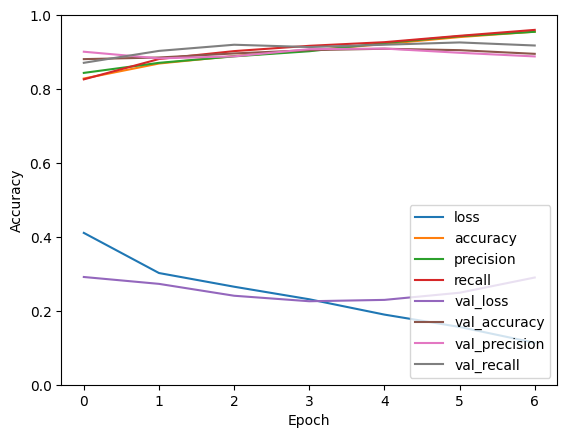

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['precision'], label = 'precision')
plt.plot(history.history['recall'], label = 'recall')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['val_precision'], label = 'val_precision')
plt.plot(history.history['val_recall'], label = 'val_recall')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

57/57 [==============================] - 14s 233ms/step


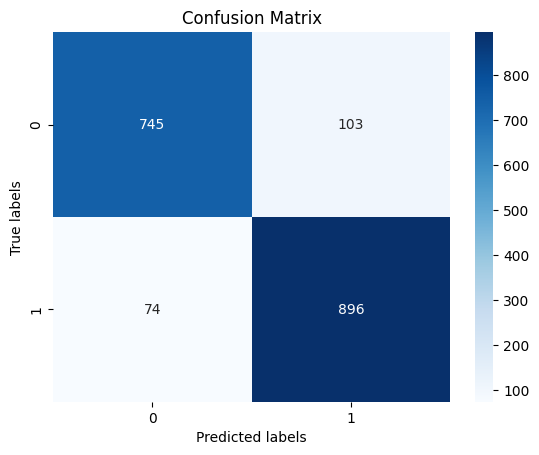

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

y_pred = model.predict(test_dataset).flatten()
y_pred = np.round(y_pred)
plot_confusion_matrix(Y_test, y_pred)

In [19]:
model.save("fire_detection_model.h5")

In [20]:
loaded_model = models.load_model("fire_detection_model.h5")